In [1]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df2 = pd.read_csv('../../data/daily_sunspots_time_series_1850-01_2024-05.csv')



In [7]:
data2 = df2[["date","counts"]]
data2['date'] = pd.to_datetime(data2['date'])




<bound method NDFrame.describe of             date  counts
0     1850-01-01     253
1     1850-01-02     162
2     1850-01-03     217
3     1850-01-04      99
4     1850-01-05     108
...          ...     ...
63668 2024-04-26     141
63669 2024-04-27     139
63670 2024-04-28     119
63671 2024-04-29     100
63672 2024-04-30      87

[63673 rows x 2 columns]>

In [23]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63673 entries, 0 to 63672
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         63673 non-null  datetime64[ns]
 1   counts       63673 non-null  int64         
 2   transformed  63673 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.5 MB


In [28]:
adfuller(data2["counts"])

(-7.565466923346992,
 2.9337380565746385e-11,
 54,
 63618,
 {'1%': -3.4304527942386707,
  '5%': -2.861585433156707,
  '10%': -2.566794182529381},
 562773.5738197217)

In [26]:
# Example of ADF test
result = adfuller(data2['counts'])
print('ADF Statistic:', result[0])
print('p-value:', result[0])

result

ADF Statistic: -7.565466923346992
p-value: -7.565466923346992


(-7.565466923346992,
 2.9337380565746385e-11,
 54,
 63618,
 {'1%': -3.4304527942386707,
  '5%': -2.861585433156707,
  '10%': -2.566794182529381},
 562773.5738197217)

In [36]:
import numpy as np
data2['log1p_transformed'] = np.log1p(data2['counts'])

data2.head()

,date,counts,transformed,log1p_transformed
0,1850-01-01,253,5.537334,5.537334
1,1850-01-02,162,5.093750,5.093750
2,1850-01-03,217,5.384495,5.384495
3,1850-01-04,99,4.605170,4.605170
4,1850-01-05,108,4.691348,4.691348


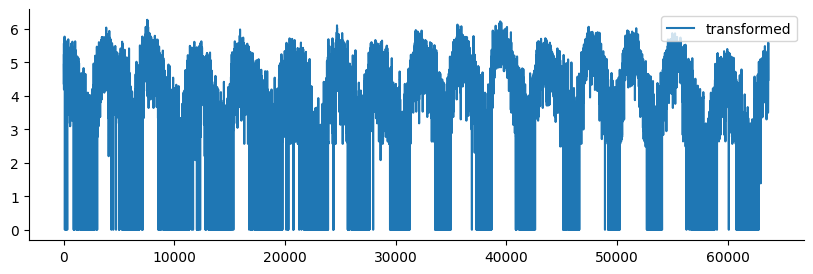

In [16]:
import matplotlib as mpl
import seaborn as sns

mpl.rc('figure',figsize=(10,3),dpi=100)

data2['transformed'].plot(legend=True)
sns.despine()

In [19]:
def qcd_variance(series,window=12):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

In [20]:
qcd_variance(data2['transformed'])

quartile coefficient of dispersion: 0.880713


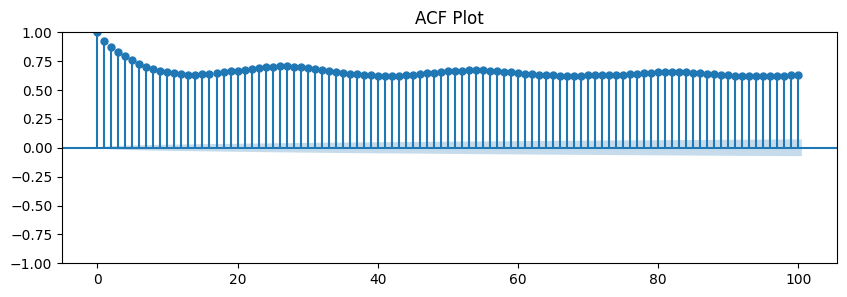

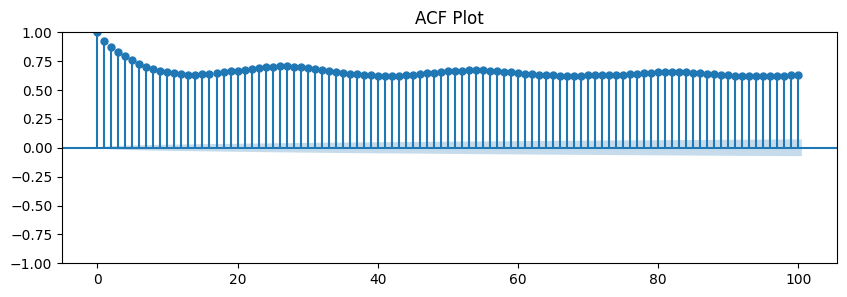

In [46]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data2["transformed"], lags=100, ax=plt.gca(), title='ACF Plot')


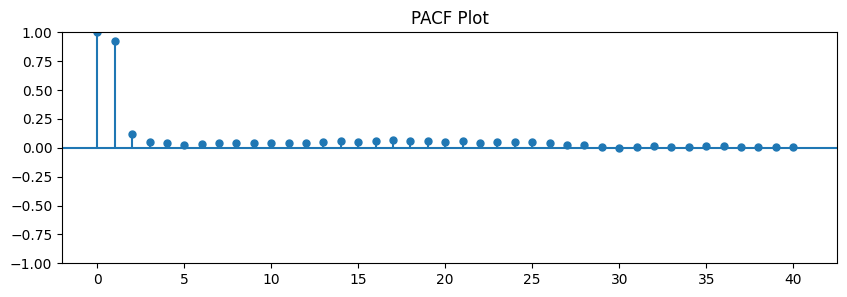

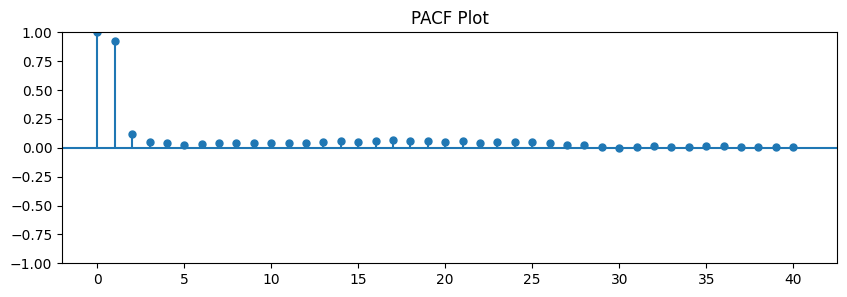

In [45]:
plot_pacf(data2["transformed"], lags=40, ax=plt.gca(), title='PACF Plot')

In [ ]:
# Frequency and sampling rate
f = 10 # frequency
Fs = 100 # sampling rate
t = np.arange(0,1,1/Fs)


# Sine function
y = np.sin(2 * np.pi * f * t)


# Perform Fourier transform using scipy
from scipy import fftpack
y_fft = fftpack.fft(y)

# Plot data
n = np.size(t)
fr = Fs/2 * np.linspace(0,1,n/2)
y_m = 2/n * abs(y_fft[0:np.size(fr)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(t, y)    # plot time series
ax[1].stem(fr, y_m) # plot freq domain

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose


seas_decomp_solaryearly = seasonal_decompose(
    x=data2['transformed'], 
    model='additive', 
    two_sided=True,
    period= 11*365)

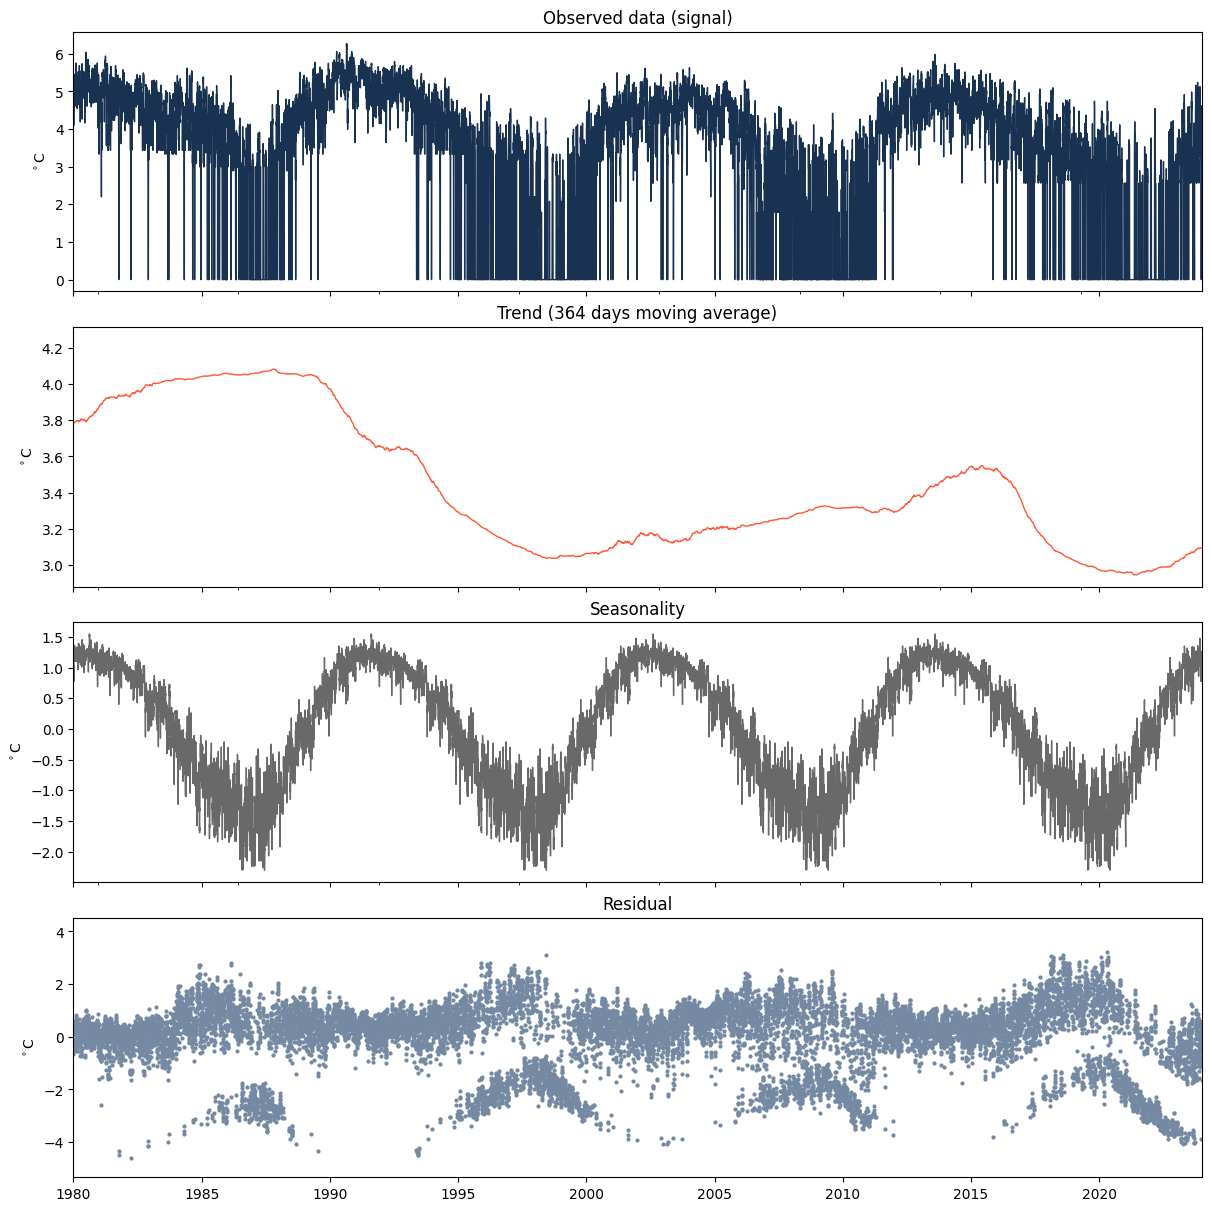

In [50]:
# Plots:
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns_c = sns.color_palette(palette=cmaps_hex)


#Plot Signal
ax[0].set(title='Observed data (signal)', 
          ylabel=r'$^\circ$C')
seas_decomp_solaryearly.observed.plot(color=sns_c[0], 
                              linewidth=1,
                              sharex=True,
                              ax=ax[0])
#Plot Trend
ax[1].set(title='Trend (364 days moving average)', 
          ylabel=r'$^\circ$C')
seas_decomp_solaryearly.trend.plot(color=sns_c[1], 
                              linewidth=1,
                              sharex=True,
                              ax=ax[1])
#Plot Seasonality
ax[2].set(title='Seasonality', 
          ylabel=r'$^\circ$C')
seas_decomp_solaryearly.seasonal.plot(
                                color=sns_c[2], 
                                linewidth=1,
                                sharex=True,
                                ax=ax[2])
#Plot residual
ax[3].set(title='Residual', 
          ylabel=r'$^\circ$C');
ax[3].scatter(
    x=seas_decomp_solaryearly.resid.index,
    y=seas_decomp_solaryearly.resid,
    color=sns_c[3],
    s=4)

for i in range(4):
    ax[i].set_xlim(pd.to_datetime("1980"),pd.to_datetime("2024"))
    
# fig.savefig("visualisations/Basel_Temp_TSA_decomp.png",dpi=300)